# Counting subjects for TRACK-ON

In [1]:
from pathlib2 import Path
import numpy as np
import pandas as pd
from collections import OrderedDict
from scipy.stats import mannwhitneyu, ks_2samp
from matplotlib import pyplot as plt


Number of subject on the orginal csv file:

In [2]:
save_outiler_csv = False

source_dir = Path('/data1/chdi_disks/Disk2/IBM SOW3-part2/'
                     'Updated TRACK phenotypic dataset')
general_ton_csv = source_dir / 'general_ton.csv'
df = pd.read_csv(general_ton_csv.as_posix(), sep='\t')

n_subjs = df['subjid'].unique().shape[0]

print('There are {} subjects in the original csv file'.format(n_subjs))

There are 245 subjects in the original csv file


Number of subject with some sort of imaging:

In [3]:
img_dir = Path('/data1/cooked/TONf')
img_subjs = len(list(img_dir.glob('R*')))
print('There are {} subjects in the image directory file'.format(img_subjs))

There are 241 subjects in the image directory file


In [4]:
raw_subj_2_visit = []
for sud in img_dir.glob('R*'):
    n_fmri = len(list(sud.glob('visit_?/Resting_State')))
    if n_fmri >=2:
        raw_subj_2_visit.append(sud.parts[-1])
raw_subj_2_visit.sort()

print('There are {} subjects with at least 2 raw Resting State visits'.format(len(raw_subj_2_visit)))

There are 225 subjects with at least 2 raw Resting State visits


In [5]:
preproc_subj_2_visit = []
n_fmri_list = []
for sud in img_dir.glob('R*'):
    n_fmri = len(list(sud.glob('visit_?/Resting_State/*_corrcomped_2_MNI.nii.gz')))
    if n_fmri >=2:
        preproc_subj_2_visit.append(sud.parts[-1])
        n_fmri_list.append(n_fmri)
preproc_df = pd.DataFrame({'subjid': preproc_subj_2_visit,
              'n_fmri': n_fmri_list})
preproc_df.set_index('subjid', inplace=True)
#preproc_subj_2_visit.sort()
print('There are {} subjects with at least 2 preprocessed Resting State visits'.format(len(preproc_subj_2_visit)))

There are 221 subjects with at least 2 preprocessed Resting State visits


In [6]:
# Create dataframe to be filled with motion and intensity outliers
# (plus a column of 'any' that contains outlier frames in either of these measures)
# per visit (3 visits):

multidx = pd.MultiIndex.from_product([preproc_subj_2_visit, range(1,4)], names=['subjid', 'visit'])
nanar = np.full((len(preproc_subj_2_visit) * 3, 3), fill_value=-1)#np.nan)
out_df = pd.DataFrame(nanar, index=multidx, columns=['intensity','motion', 'any'])

for subjid in preproc_subj_2_visit:
    for vix in range(1,4):
        parent = img_dir / subjid / 'visit_{}'.format(vix) / 'Resting_State'
        try:
            out_csv = parent.glob('*_outliers.csv').next()
        except StopIteration:
            out_csv = ''
        if out_csv:
            this_out = pd.read_csv(out_csv)
            this_out['any'] = this_out['intensity'] | this_out['motion']
            this_vals = this_out[['intensity', 'motion', 'any']].sum()
            
            out_df.at[subjid, vix] = this_vals.astype(int)

if save_outiler_csv:
    out_fn = Path().cwd() / 'motion_outlier_table.csv'
    out_df.to_csv(out_fn)

In [7]:
n_frame_thres = 10

# Compare with old computation from preprocessing/make_fmri_motion_exclusion_list:
old_list_fn = ('/data2/polo/half_baked_data/TON_rsfMRI/'
               'outlier_runs.csv')
old_df = pd.read_csv(old_list_fn)

assert old_df.loc[old_df['subjid'].isin(preproc_subj_2_visit)].shape[0] == (out_df['any'] > n_frame_thres).sum()

z = (out_df['any'] > n_frame_thres).unstack().sum(axis=1)
z.name = preproc_df.columns[0]
subject_ok_visits = preproc_df - z.to_frame()
print('Of the {} subjects with at least 2 preprocessed Resting State visits,'
      'there are {} with ok motion'.format(len(preproc_subj_2_visit),
                                           (subject_ok_visits >=2)['n_fmri'].sum()))


Of the 221 subjects with at least 2 preprocessed Resting State visits,there are 217 with ok motion


In [8]:
fine_motion_subjs = (subject_ok_visits >=2)['n_fmri']
new_subj_array = fine_motion_subjs[fine_motion_subjs].index.values
inclusion_df = pd.read_csv('inclusion_df.csv', index_col='subjid')

requirement_list = ['is_control_or_has_CAG', 'is_control_or_has_CAP',
                    'never_converted', 'righthanded', 'slopes_in_all_tasks']
req_name = requirement_list[0]

for req_name in requirement_list:
    this_inclusion = inclusion_df.loc[new_subj_array]
    this_inclusion[req_name].sum()
    print('Out of {}, only {} satisfied {}'.format(new_subj_array.shape[0],
                                                   this_inclusion[req_name].sum(),
                                                   req_name))
    new_subj_array = this_inclusion[req_name][this_inclusion[req_name]].index.values




Out of 217, only 217 satisfied is_control_or_has_CAG
Out of 217, only 217 satisfied is_control_or_has_CAP
Out of 217, only 207 satisfied never_converted
Out of 207, only 185 satisfied righthanded
Out of 185, only 171 satisfied slopes_in_all_tasks


In [9]:
#
#First some subjects are excluded due to poor correlation with median
# 
# Subjects with files not found:
# /data2/polo/code/MLtool/TON_resting_classification/subjects_not_found.csv
#Poorly registered subject: R800031338
#not found subjects:/data2/polo/code/MLtool/TON_resting_classification/subjects_not_found.csv

subj_not_found = '/data2/polo/code/MLtool/TON_resting_classification/subjects_not_found.csv'
subj_not_found_arr = pd.read_csv(subj_not_found,header=None).values.flatten()
subj_not_found_arr = np.r_[subj_not_found_arr, np.array(['R800031338'])]
found_subj = new_subj_array[~np.in1d(new_subj_array, subj_not_found_arr)]

print('Out of {}, only {} satisfied {}'.format(new_subj_array.shape[0],
                                               found_subj.shape[0],
                                               'having found fmri file by matlab'))

Out of 171, only 153 satisfied having found fmri file by matlab


/home/CHDI/opt/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


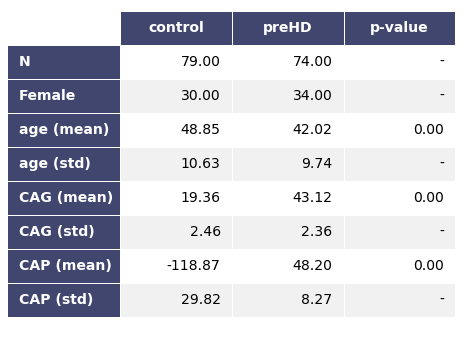

In [13]:
dem_csv = '/data2/polo/half_baked_data/TON_baseline_demo.csv'
dem_df = pd.read_csv(dem_csv, index_col='subjid').loc[found_subj].copy()
dem_df['ones'] = 1

import dataframe_to_table as dt

dict_to_show = OrderedDict([
                            ('N', dem_df.groupby('group').count()['ones']),
                            ('Female', dem_df.groupby('group').sum()['sex']),
                            ('age (mean)', dem_df.groupby(['group'])['age'].mean()),
                            ('age (std)', dem_df.groupby(['group'])['age'].std()),
                            ('CAG (mean)',  dem_df.groupby(['group'])['CAG'].mean()),
                            ('CAG (std)',  dem_df.groupby(['group'])['CAG'].std()),
                            ('CAP (mean)',  dem_df.groupby(['group'])['CAP'].mean()),
                            ('CAP (std)',  dem_df.groupby(['group'])['CAP'].std())
                            ])
h = pd.DataFrame(dict_to_show).T
h['p-value'] = np.nan

for key in dict_to_show.keys():
    if 'mean' in key:
        col = key.split(' ')[0]
        rows = OrderedDict()
        for group in dem_df.group.unique():
            rows[group] = dem_df.loc[dem_df['group'] == group][col].values
        #p_val = mannwhitneyu(*rows.values(),alternative='two-sided')[1]
        p_val = ks_2samp(*rows.values())[1]
        h.loc[key, 'p-value'] = p_val
ah = dt.render_mpl_table(h, header_columns=0, col_width=2.0,
                         rowLabels=h.index.values)
fh = ah.get_figure()
fh.show()